# Построение классификатора болезни Паркинсона по информации о нарисованных спиралях

## Задание 1. Подготовка и анализ данных

### Импорт окружения

In [4]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128


In [6]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA not available for PyTorch.")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4050 Laptop GPU


In [8]:
# Импорт необходимых библиотек
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [9]:
# Настройки для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Определим устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Загрузка датасета

In [11]:
# 1.1 Загрузка датасета
data_path_control = "dataset/control/"
data_path_parkinson = "dataset/parkinson/"

control_files = glob.glob(os.path.join(data_path_control, "*.txt"))
parkinson_files = glob.glob(os.path.join(data_path_parkinson, "*.txt"))

all_patients_data = []
# Определяем имена колонок согласно описанию и примеру файла
column_names = ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Timestamp', 'Test ID']

# Загрузка данных здоровых пациентов
for file_path in control_files:
    try:
        # ИЗМЕНЕНИЕ: Добавлены header=None и names=column_names
        df = pd.read_csv(file_path, sep=';', header=None, names=column_names)
        df['Outcome'] = 0 # 0 для здоровых
        df['PatientID'] = os.path.basename(file_path)
        all_patients_data.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        # Добавим вывод проблемного DataFrame для отладки, если чтение прошло, но ошибка на других этапах
        try:
            print(f"Content preview of problematic file {file_path}:")
            temp_df = pd.read_csv(file_path, sep=';', header=None)
            print(temp_df.head())
        except Exception as e_read:
             print(f"Could not even preview {file_path}: {e_read}")


# Загрузка данных пациентов с Паркинсоном
for file_path in parkinson_files:
    try:
        # ИЗМЕНЕНИЕ: Добавлены header=None и names=column_names
        df = pd.read_csv(file_path, sep=';', header=None, names=column_names)
        df['Outcome'] = 1 # 1 для больных
        df['PatientID'] = os.path.basename(file_path)
        all_patients_data.append(df)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        # Добавим вывод проблемного DataFrame для отладки
        try:
            print(f"Content preview of problematic file {file_path}:")
            temp_df = pd.read_csv(file_path, sep=';', header=None)
            print(temp_df.head())
        except Exception as e_read:
             print(f"Could not even preview {file_path}: {e_read}")


if not all_patients_data:
    # Если данные не загрузились, выведем информацию о файлах
    print(f"Control files found: {control_files}")
    print(f"Parkinson files found: {parkinson_files}")
    raise ValueError("No data loaded. Check paths, file formats, and if files are empty or corrupted.")

print(f"Загружено данных по {len(all_patients_data)} пациентам.")

# Пример данных одного пациента
print("\nПример данных одного пациента (после загрузки с именами колонок):")
print(all_patients_data[0].head())
print(f"\nТипы данных в первом DataFrame:")
print(all_patients_data[0].dtypes)
print(f"\nУникальные Test ID в первом DataFrame: {all_patients_data[0]['Test ID'].unique()}")

Загружено данных по 40 пациентам.

Пример данных одного пациента (после загрузки с именами колонок):
     X    Y  Z  Pressure  GripAngle   Timestamp  Test ID  Outcome   PatientID
0  200  204  0        73        910  1732647300        0        0  C_0001.txt
1  200  204  0       218        900  1732647307        0        0  C_0001.txt
2  200  204  0       253        900  1732647314        0        0  C_0001.txt
3  200  204  0       304        900  1732647321        0        0  C_0001.txt
4  200  204  0       351        900  1732647328        0        0  C_0001.txt

Типы данных в первом DataFrame:
X             int64
Y             int64
Z             int64
Pressure      int64
GripAngle     int64
Timestamp     int64
Test ID       int64
Outcome       int64
PatientID    object
dtype: object

Уникальные Test ID в первом DataFrame: [0 1]


### Визуализация координат

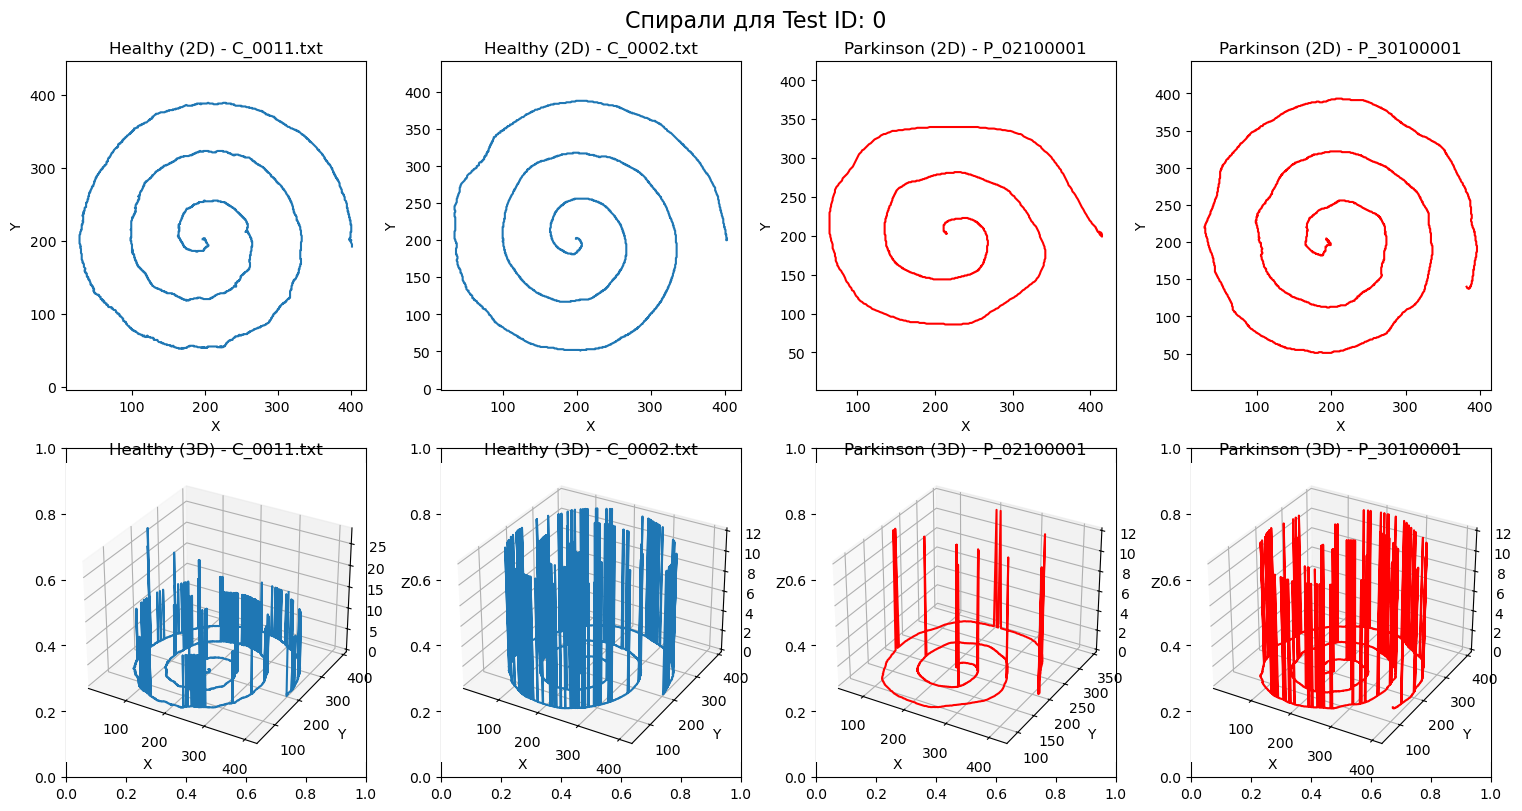


Видение отличий больных от здоровых по визуализации:
На визуализациях (особенно если данные реальные, а не случайные) можно ожидать, что:
- У пациентов с болезнью Паркинсона спирали могут быть менее плавными, с большим количеством "дрожаний" (тремора).
- Форма спирали может быть искажена, менее округлой или равномерной.
- Размер спирали может быть меньше (микрография).
- В 3D может быть заметна изменчивость по оси Z, отражающая неустойчивость нажатия или подъема руки.
- Динамические тесты (Test ID 1) или тесты круговых движений (Test ID 2) могут сильнее выявлять проблемы с координацией.



In [13]:
# 2.1. Визуализация координат
def plot_spirals(patient_data_list, num_samples=2, test_ids_to_plot=None):
    if test_ids_to_plot is None:
        test_ids_to_plot = [0, 1, 2] # По умолчанию все типы тестов

    # Разделяем пациентов на здоровых и больных для примера
    healthy_patients = [p for p in patient_data_list if p['Outcome'].iloc[0] == 0]
    parkinson_patients = [p for p in patient_data_list if p['Outcome'].iloc[0] == 1]

    if not healthy_patients or not parkinson_patients:
        print("Not enough diverse patient data for visualization.")
        return

    for test_id_val in test_ids_to_plot:
        fig, axes = plt.subplots(2, num_samples * 2, figsize=(15, 8), constrained_layout=True)
        fig.suptitle(f'Спирали для Test ID: {test_id_val}', fontsize=16)

        # Здоровые
        sampled_healthy = random.sample(healthy_patients, min(num_samples, len(healthy_patients)))
        for i, patient_df in enumerate(sampled_healthy):
            test_df = patient_df[patient_df['Test ID'] == test_id_val].sort_values(by='Timestamp')
            if not test_df.empty:
                # 2D plot
                ax_2d = axes[0, i]
                ax_2d.plot(test_df['X'], test_df['Y'])
                ax_2d.set_title(f'Healthy (2D) - {patient_df["PatientID"].iloc[0][:10]}')
                ax_2d.set_xlabel('X')
                ax_2d.set_ylabel('Y')
                ax_2d.axis('equal')

                # 3D plot
                ax_3d = fig.add_subplot(2, num_samples * 2, num_samples * 2 + i + 1, projection='3d') # Manually position 3D plots
                ax_3d.plot(test_df['X'], test_df['Y'], test_df['Z'])
                ax_3d.set_title(f'Healthy (3D) - {patient_df["PatientID"].iloc[0][:10]}')
                ax_3d.set_xlabel('X')
                ax_3d.set_ylabel('Y')
                ax_3d.set_zlabel('Z')
            else:
                axes[0, i].set_title(f'Healthy - No data for Test ID {test_id_val}')
                fig.delaxes(axes[1,i]) # Remove unused 3D subplot axis

        # Больные
        sampled_parkinson = random.sample(parkinson_patients, min(num_samples, len(parkinson_patients)))
        for i, patient_df in enumerate(sampled_parkinson):
            test_df = patient_df[patient_df['Test ID'] == test_id_val].sort_values(by='Timestamp')
            if not test_df.empty:
                # 2D plot
                ax_2d = axes[0, num_samples + i]
                ax_2d.plot(test_df['X'], test_df['Y'], color='red')
                ax_2d.set_title(f'Parkinson (2D) - {patient_df["PatientID"].iloc[0][:10]}')
                ax_2d.set_xlabel('X')
                ax_2d.set_ylabel('Y')
                ax_2d.axis('equal')

                # 3D plot
                ax_3d = fig.add_subplot(2, num_samples*2, num_samples*2 + num_samples + i + 1, projection='3d')
                ax_3d.plot(test_df['X'], test_df['Y'], test_df['Z'], color='red')
                ax_3d.set_title(f'Parkinson (3D) - {patient_df["PatientID"].iloc[0][:10]}')
                ax_3d.set_xlabel('X')
                ax_3d.set_ylabel('Y')
                ax_3d.set_zlabel('Z')
            else:
                axes[0, num_samples + i].set_title(f'Parkinson - No data for Test ID {test_id_val}')
                fig.delaxes(axes[1, num_samples + i])


        plt.show()

plot_spirals(all_patients_data, num_samples=2, test_ids_to_plot=[0]) # Посмотрим на статичный тест

print("""
Видение отличий больных от здоровых по визуализации:
На визуализациях (особенно если данные реальные, а не случайные) можно ожидать, что:
- У пациентов с болезнью Паркинсона спирали могут быть менее плавными, с большим количеством "дрожаний" (тремора).
- Форма спирали может быть искажена, менее округлой или равномерной.
- Размер спирали может быть меньше (микрография).
- В 3D может быть заметна изменчивость по оси Z, отражающая неустойчивость нажатия или подъема руки.
- Динамические тесты (Test ID 1) или тесты круговых движений (Test ID 2) могут сильнее выявлять проблемы с координацией.
""")

### Изучение параметров распределения 

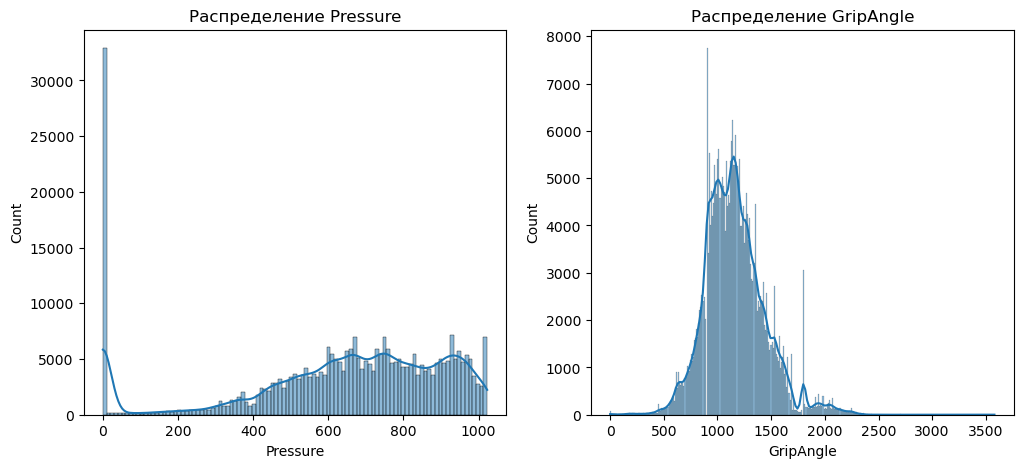

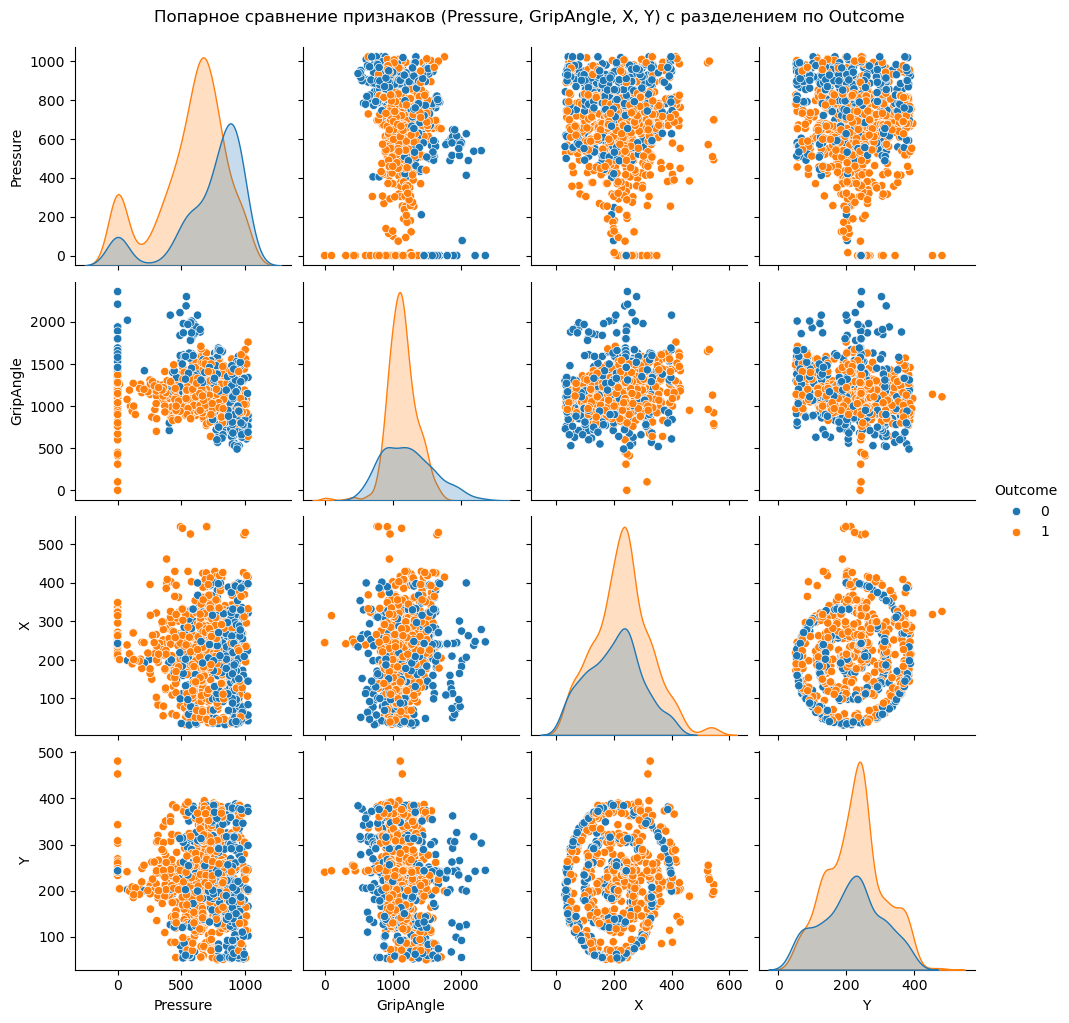

In [15]:
# 2.2. Изучение параметров распределения (Pressure, GripAngle)
# Объединим все данные для анализа распределений
combined_df_list = []
for patient_df in all_patients_data:
    # Упорядочим по Timestamp перед объединением, на случай если это не сделано
    combined_df_list.append(patient_df.sort_values(by='Timestamp'))

combined_df = pd.concat(combined_df_list, ignore_index=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(combined_df['Pressure'], kde=True)
plt.title('Распределение Pressure')
plt.subplot(1, 2, 2)
sns.histplot(combined_df['GripAngle'], kde=True)
plt.title('Распределение GripAngle')
plt.show()

# Попарное сравнение признаков (выборочно, чтобы не перегружать)
sample_df_for_pairplot = combined_df[['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Outcome']].sample(n=min(1000, len(combined_df)), random_state=SEED)
sns.pairplot(sample_df_for_pairplot, hue='Outcome', vars=['Pressure', 'GripAngle', 'X', 'Y']) # Добавим X, Y для интереса
plt.suptitle('Попарное сравнение признаков (Pressure, GripAngle, X, Y) с разделением по Outcome', y=1.02)
plt.show()

### 1.3 Сравнение распределений по колонкам у разных классов

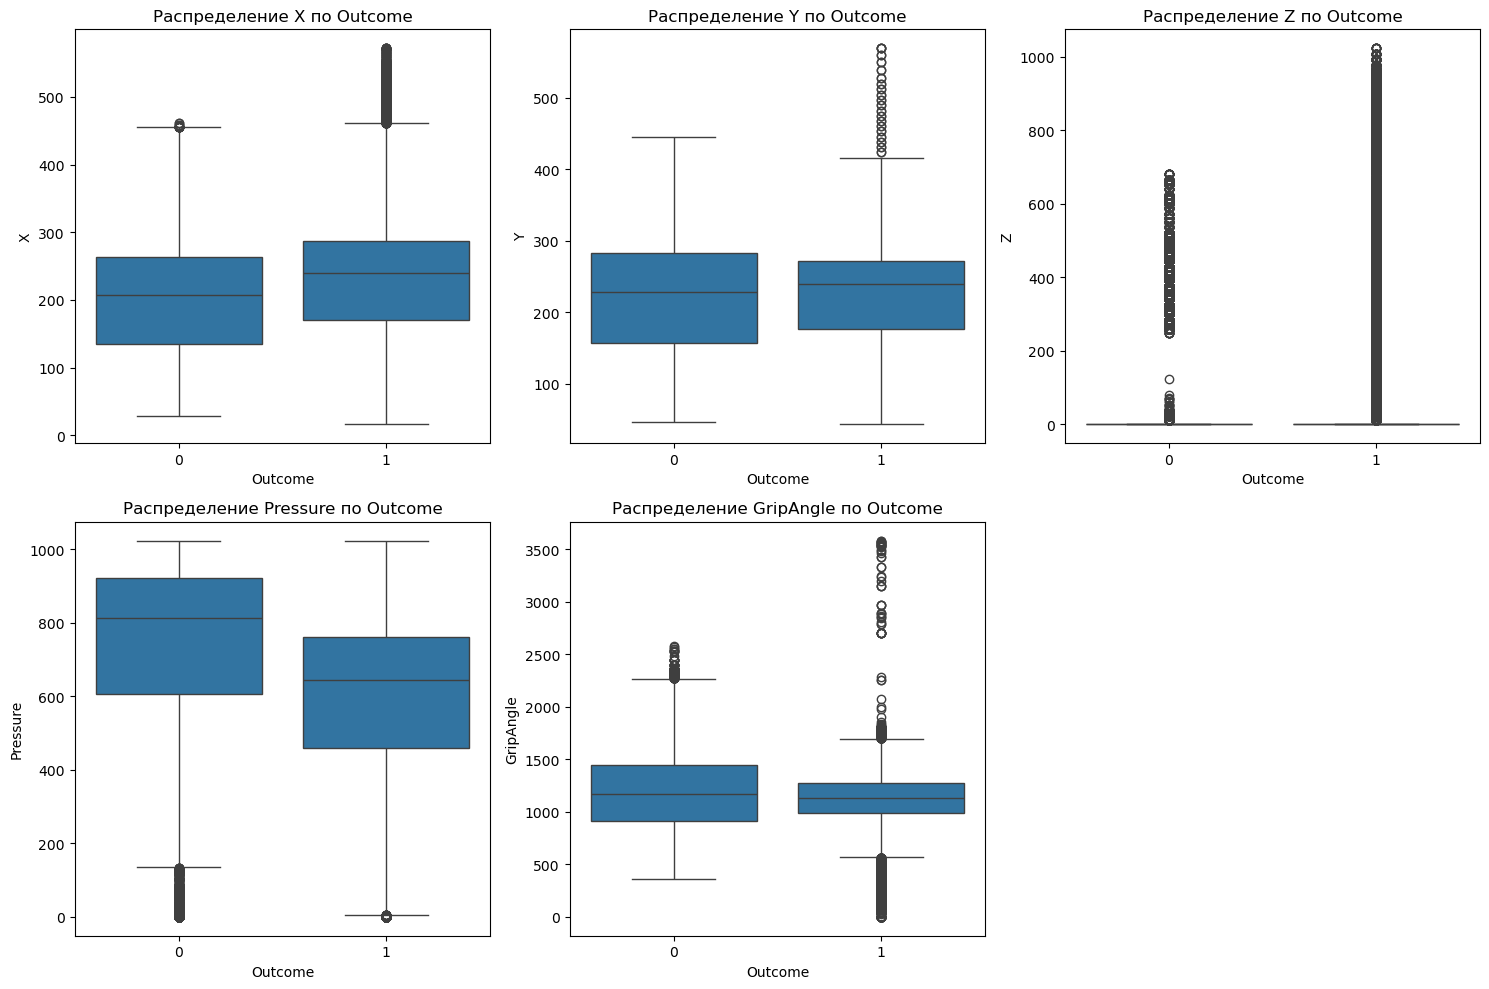


Анализ распределений:
- Pressure: Можно ожидать, что у пациентов с Паркинсоном сила нажатия может быть слабее или более вариативной.
- GripAngle: Угол наклона ручки также может отличаться, возможно, из-за тремора или ригидности.
- Координаты X, Y, Z: Распределения могут показать различия в размахе движений.



In [17]:
# 2.3. Сравнение распределений по колонкам у разных классов
plt.figure(figsize=(15, 10))
features_to_compare = ['X', 'Y', 'Z', 'Pressure', 'GripAngle']
for i, col in enumerate(features_to_compare):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Outcome', y=col, data=combined_df)
    plt.title(f'Распределение {col} по Outcome')
plt.tight_layout()
plt.show()

print("""
Анализ распределений:
- Pressure: Можно ожидать, что у пациентов с Паркинсоном сила нажатия может быть слабее или более вариативной.
- GripAngle: Угол наклона ручки также может отличаться, возможно, из-за тремора или ригидности.
- Координаты X, Y, Z: Распределения могут показать различия в размахе движений.
""")

### 1.4 Удаление колонки Timestamp

In [19]:
# 2.4. Удаление колонки Timestamp
# Колонку Timestamp мы уже использовали для упорядочивания данных внутри каждого теста.
# Для обучения RNN сама по себе абсолютная временная метка не нужна, так как важен порядок событий.
# Поэтому на этапе подготовки данных для модели мы ее удалим из признаков.
# Однако, она важна для предварительной сортировки данных в каждом файле!

# Создадим копию списка датафреймов для дальнейшей обработки
processed_patients_data = []
for df in all_patients_data:
    # Убедимся, что данные отсортированы по Timestamp перед его удалением
    df_sorted = df.sort_values(by='Timestamp').copy()
    df_processed = df_sorted.drop(columns=['Timestamp'])
    processed_patients_data.append(df_processed)

print("Колонка Timestamp удалена после сортировки данных.")
print("Пример данных после удаления Timestamp:")
print(processed_patients_data[0].head())

print("""
Мнение о бесполезности Timestamp для предсказания:
Колонка Timestamp представляет собой абсолютное время записи каждой точки.
Для рекуррентных сетей важна последовательность данных, а не абсолютное время.
Порядок точек уже задан их следованием в файле (после сортировки по Timestamp).
Если бы мы анализировали скорость рисования как признак, то могли бы вычислить разницы Timestamp (dt),
но для текущей задачи классификации на основе последовательности X,Y,Z,Pressure,GripAngle,TestID,
сама колонка Timestamp как прямой признак не несет информации о наличии заболевания,
которая не была бы уже закодирована в порядке и значениях других признаков.
Она полезна для упорядочивания, но не как фича для RNN в данном контексте.
""")

Колонка Timestamp удалена после сортировки данных.
Пример данных после удаления Timestamp:
        X    Y  Z  Pressure  GripAngle  Test ID  Outcome   PatientID
2578  200  203  0        66        800        1        0  C_0001.txt
2579  200  203  0       136        800        1        0  C_0001.txt
2580  200  203  0       196        800        1        0  C_0001.txt
2581  200  203  0       248        820        1        0  C_0001.txt
2582  200  203  0       289        810        1        0  C_0001.txt

Мнение о бесполезности Timestamp для предсказания:
Колонка Timestamp представляет собой абсолютное время записи каждой точки.
Для рекуррентных сетей важна последовательность данных, а не абсолютное время.
Порядок точек уже задан их следованием в файле (после сортировки по Timestamp).
Если бы мы анализировали скорость рисования как признак, то могли бы вычислить разницы Timestamp (dt),
но для текущей задачи классификации на основе последовательности X,Y,Z,Pressure,GripAngle,TestID,
сама кол

### 1.5 Разделение датасета на обучающий и тестовый ПО ПАЦИЕНТАМ

In [21]:
# Разделение датасета на обучающий и тестовый ПО ПАЦИЕНТАМ
patient_ids = np.array([df['PatientID'].iloc[0] for df in processed_patients_data])
outcomes = np.array([df['Outcome'].iloc[0] for df in processed_patients_data])

control_patient_ids = patient_ids[outcomes == 0]
parkinson_patient_ids = patient_ids[outcomes == 1]

# Проверка на достаточное количество пациентов
if len(control_patient_ids) < 3 or len(parkinson_patient_ids) < 5:
    raise ValueError(f"Not enough patients for specified test split. Healthy: {len(control_patient_ids)}, Parkinson: {len(parkinson_patient_ids)}")

# Случайный выбор пациентов для теста
test_control_ids = random.sample(list(control_patient_ids), 3)
test_parkinson_ids = random.sample(list(parkinson_patient_ids), 5)
test_patient_ids = test_control_ids + test_parkinson_ids

train_patient_ids = [pid for pid in patient_ids if pid not in test_patient_ids]

# Формируем списки данных для train и test
train_data_raw = [df for df in processed_patients_data if df['PatientID'].iloc[0] in train_patient_ids]
test_data_raw = [df for df in processed_patients_data if df['PatientID'].iloc[0] in test_patient_ids]

print(f"Количество пациентов в обучающей выборке: {len(train_data_raw)}")
print(f"Количество пациентов в тестовой выборке: {len(test_data_raw)}")
print(f"Пример ID пациентов в тесте: {test_patient_ids[:2]}")

Количество пациентов в обучающей выборке: 32
Количество пациентов в тестовой выборке: 8
Пример ID пациентов в тесте: ['C_0005.txt', 'C_0004.txt']


### 1.6 Нормализация данных

In [23]:
# Нормализация данных
# Координаты X, Y, Z: вычитание среднего арифметического для КАЖДОЙ последовательности (пациента)
# Остальные числовые признаки (Pressure, GripAngle) и OHE Test ID: StandardScaler

# Сначала обработаем Test ID с помощью OneHotEncoder
# Собираем все уникальные значения Test ID для обучения энкодера
all_test_ids_train = pd.concat([df[['Test ID']] for df in train_data_raw])['Test ID'].unique().reshape(-1, 1)
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # handle_unknown на случай если в тесте встретится ID, которого не было в трейне
one_hot_encoder.fit(all_test_ids_train)
ohe_feature_names = one_hot_encoder.get_feature_names_out(['TestID'])

# Определяем числовые признаки для StandardScaler (кроме X, Y, Z)
numerical_features_for_scaler = ['Pressure', 'GripAngle']

# Подготовка данных для обучения StandardScaler
# Собираем все данные этих признаков из ТРЕНИРОВОЧНОЙ выборки
temp_train_dfs_for_scaler = []
for df_patient_raw in train_data_raw:
    # OHE для Test ID
    test_id_ohe = one_hot_encoder.transform(df_patient_raw[['Test ID']])
    df_ohe = pd.DataFrame(test_id_ohe, columns=ohe_feature_names, index=df_patient_raw.index)
    
    # Объединяем с Pressure, GripAngle
    df_for_scaler_patient = pd.concat([df_patient_raw[numerical_features_for_scaler], df_ohe], axis=1)
    temp_train_dfs_for_scaler.append(df_for_scaler_patient)

if not temp_train_dfs_for_scaler:
    raise ValueError("Training data for scaler is empty. Check previous steps.")

all_train_features_for_scaler = pd.concat(temp_train_dfs_for_scaler, ignore_index=True)

scaler = StandardScaler()
scaler.fit(all_train_features_for_scaler)

# Функция для препроцессинга одного датафрейма пациента
def preprocess_patient_df(df_patient_raw, ohe, scaler_obj, ohe_cols, num_cols_scaler):
    df_copy = df_patient_raw.copy()

    # 1. Координаты: вычитание среднего
    for coord in ['X', 'Y', 'Z']:
        df_copy[coord] = df_copy[coord] - df_copy[coord].mean()

    # 2. One-Hot Encoding для 'Test ID'
    test_id_ohe_values = ohe.transform(df_copy[['Test ID']])
    df_ohe = pd.DataFrame(test_id_ohe_values, columns=ohe_cols, index=df_copy.index)

    # 3. Собираем признаки для StandardScaler (Pressure, GripAngle + OHE TestID)
    features_to_scale = pd.concat([df_copy[num_cols_scaler], df_ohe], axis=1)
    
    # 4. StandardScaler
    scaled_features = scaler_obj.transform(features_to_scale)
    df_scaled_features = pd.DataFrame(scaled_features, columns=features_to_scale.columns, index=df_copy.index)

    # 5. Объединяем все признаки
    # Берем нормализованные X,Y,Z и отскейленные Pressure, GripAngle, OHE TestID
    final_df = pd.concat([df_copy[['X', 'Y', 'Z']], df_scaled_features], axis=1)
    
    # Добавляем Outcome и PatientID обратно (они не фичи для модели, но нужны для Dataset)
    final_df['Outcome'] = df_copy['Outcome']
    final_df['PatientID'] = df_copy['PatientID']
    
    return final_df

# Применяем препроцессинг
train_data_processed = [preprocess_patient_df(df, one_hot_encoder, scaler, ohe_feature_names, numerical_features_for_scaler) for df in train_data_raw]
test_data_processed = [preprocess_patient_df(df, one_hot_encoder, scaler, ohe_feature_names, numerical_features_for_scaler) for df in test_data_raw]


feature_columns = ['X', 'Y', 'Z'] + numerical_features_for_scaler + list(ohe_feature_names)
print(f"\nИтоговые признаки для модели: {feature_columns}")
print(f"Количество признаков: {len(feature_columns)}")

print("\nПример обработанных данных (первый пациент из обучающей выборки):")
print(train_data_processed[0].head())
print("\nСтатистика по X (должна быть около 0):")
print(train_data_processed[0]['X'].describe())


Итоговые признаки для модели: ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'TestID_0', 'TestID_1', 'TestID_2']
Количество признаков: 8

Пример обработанных данных (первый пациент из обучающей выборки):
             X         Y        Z  Pressure  GripAngle  TestID_0  TestID_1  \
2578  2.753103 -7.079655 -0.57931 -1.988217  -1.338895  -0.83967  1.137432   
2579  2.753103 -7.079655 -0.57931 -1.740342  -1.338895  -0.83967  1.137432   
2580  2.753103 -7.079655 -0.57931 -1.527877  -1.338895  -0.83967  1.137432   
2581  2.753103 -7.079655 -0.57931 -1.343741  -1.263125  -0.83967  1.137432   
2582  2.753103 -7.079655 -0.57931 -1.198557  -1.301010  -0.83967  1.137432   

      TestID_2  Outcome   PatientID  
2578 -0.420952        0  C_0001.txt  
2579 -0.420952        0  C_0001.txt  
2580 -0.420952        0  C_0001.txt  
2581 -0.420952        0  C_0001.txt  
2582 -0.420952        0  C_0001.txt  

Статистика по X (должна быть около 0):
count    5.800000e+03
mean    -1.003580e-14
std      9.552397e+0

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\A

## Задание 2. Создание и обучение моделей нейронной сети

### 2.1 Создание PyTorch Dataset и DataLoader

In [26]:
# Создание PyTorch Dataset и DataLoader

class ParkinsonDataset(Dataset):
    def __init__(self, data_list, feature_cols):
        self.sequences = []
        self.labels = []
        self.lengths = []

        for patient_df in data_list:
            # Убедимся, что PatientID и Outcome согласованы для всех строк
            # (хотя они должны быть одинаковыми для одного пациента)
            self.sequences.append(torch.tensor(patient_df[feature_cols].values, dtype=torch.float32))
            self.labels.append(torch.tensor(patient_df['Outcome'].iloc[0], dtype=torch.float32)) # одна метка на пациента
            self.lengths.append(len(patient_df))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx], self.lengths[idx]

def collate_fn(batch):
    sequences, labels, lengths = zip(*batch)
    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    # Stack labels and lengths
    labels = torch.stack(labels)
    lengths = torch.tensor(lengths, dtype=torch.long) # Длины для pack_padded_sequence
    return padded_sequences, labels, lengths


train_dataset = ParkinsonDataset(train_data_processed, feature_columns)
test_dataset = ParkinsonDataset(test_data_processed, feature_columns)

# Для решения проблемы дисбаланса классов, если он есть, можно использовать WeightedRandomSampler
# Подсчитаем классы в трейне
train_labels_list = [df['Outcome'].iloc[0] for df in train_data_raw]
class_counts = pd.Series(train_labels_list).value_counts().sort_index()
if not class_counts.empty and len(class_counts) == 2: # Убедимся, что есть оба класса
    class_weights = 1. / class_counts.values
    sample_weights = [class_weights[label] for label in train_labels_list]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, collate_fn=collate_fn) # Увеличил batch_size
else: # Если только один класс или пустые данные
    print("Warning: Not enough class diversity for WeightedRandomSampler or no training data. Using standard DataLoader.")
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


print(f"\nРазмер обучающего датасета: {len(train_dataset)}")
print(f"Размер тестового датасета: {len(test_dataset)}")
# Проверим один батч
if len(train_loader) > 0:
    sample_batch_sequences, sample_batch_labels, sample_batch_lengths = next(iter(train_loader))
    print(f"\nФорма батча последовательностей: {sample_batch_sequences.shape}") # (batch_size, max_seq_len, num_features)
    print(f"Форма батча меток: {sample_batch_labels.shape}")         # (batch_size)
    print(f"Пример длин последовательностей в батче: {sample_batch_lengths[:5]}")
else:
    print("\nTrain loader is empty. Cannot fetch a sample batch.")

INPUT_SIZE = len(feature_columns) # Количество признаков


Размер обучающего датасета: 32
Размер тестового датасета: 8

Форма батча последовательностей: torch.Size([16, 22794, 8])
Форма батча меток: torch.Size([16])
Пример длин последовательностей в батче: tensor([6815, 8007, 6815, 5595, 6677])


### Задание 2.2 Создание и обучение моделей нейронной сети


--- Training Simple RNN ---
Starting training for 50 epochs on cuda...
Epoch [1/50], Loss: 0.6516
Epoch [5/50], Loss: 0.4939
Epoch [10/50], Loss: 0.4411
Epoch [15/50], Loss: 0.3454
Epoch [20/50], Loss: 0.4854
Epoch [25/50], Loss: 0.2700
Epoch [30/50], Loss: 0.1608
Epoch [35/50], Loss: 0.3560
Epoch [40/50], Loss: 0.2226
Epoch [45/50], Loss: 0.1634
Epoch [50/50], Loss: 0.1105
Training finished.


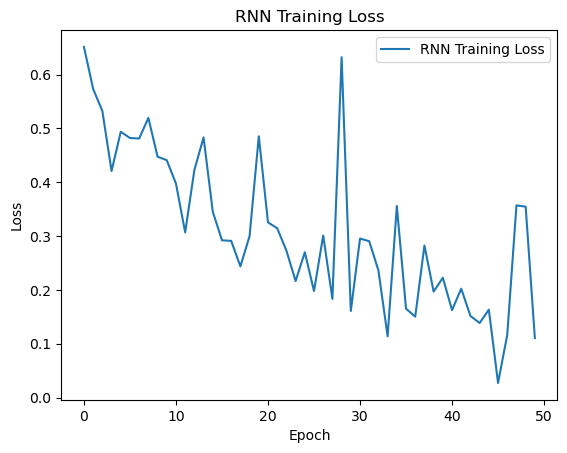


--- Training LSTM ---
Starting training for 50 epochs on cuda...
Epoch [1/50], Loss: 0.6621
Epoch [5/50], Loss: 0.5136
Epoch [10/50], Loss: 0.3646
Epoch [15/50], Loss: 0.5586
Epoch [20/50], Loss: 0.3446
Epoch [25/50], Loss: 0.1918
Epoch [30/50], Loss: 0.3153
Epoch [35/50], Loss: 0.3316
Epoch [40/50], Loss: 0.1930
Epoch [45/50], Loss: 0.0991
Epoch [50/50], Loss: 0.0653
Training finished.


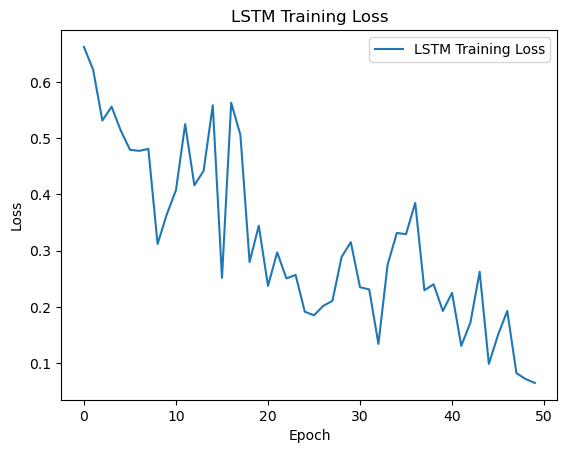


--- Training GRU ---
Starting training for 50 epochs on cuda...
Epoch [1/50], Loss: 0.7003
Epoch [5/50], Loss: 0.4018
Epoch [10/50], Loss: 0.4725
Epoch [15/50], Loss: 0.2391
Epoch [20/50], Loss: 0.2551
Epoch [25/50], Loss: 0.2161
Epoch [30/50], Loss: 0.0762
Epoch [35/50], Loss: 0.1014
Epoch [40/50], Loss: 0.0215
Epoch [45/50], Loss: 0.0099
Epoch [50/50], Loss: 0.0107
Training finished.


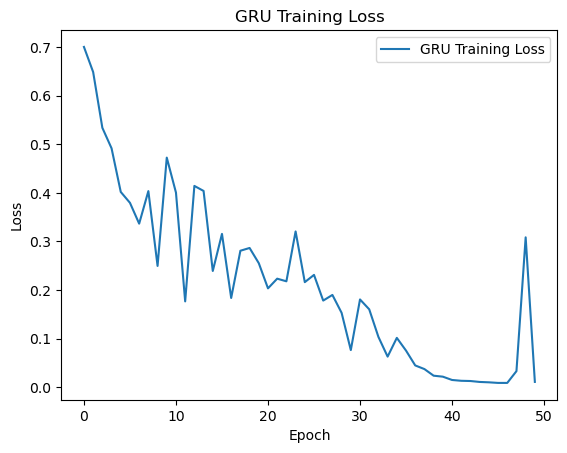

In [28]:
# Задание 2. Создание и обучение моделей нейронной сети

# Общая функция для обучения
def train_model(model, train_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    model.train()
    history = {'loss': []}
    print(f"Starting training for {num_epochs} epochs on {device}...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, lengths in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            # Для моделей, которые могут использовать pack_padded_sequence
            # lengths нужно передать на тот же девайс, что и sequences, и отсортировать
            lengths_cpu = lengths.cpu() # pack_padded_sequence ожидает длины на CPU
            
            optimizer.zero_grad()
            outputs = model(sequences, lengths_cpu) # передаем lengths_cpu
            
            loss = criterion(outputs.squeeze(), labels) # labels уже float32
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * sequences.size(0) # Умножаем на batch size

        avg_epoch_loss = epoch_loss / len(train_loader.dataset)
        history['loss'].append(avg_epoch_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    print("Training finished.")
    return history

# Базовая модель RNN, LSTM, GRU
class RNNBase(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, rnn_type='RNN', dropout=0.2, output_activation='sigmoid'):
        super(RNNBase, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.upper()

        if self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        else: # 'RNN'
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, nonlinearity='tanh')
        
        self.fc = nn.Linear(hidden_size, 1) # Выход - 1 значение для бинарной классификации
        
        if output_activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif output_activation == 'tanh':
            self.activation = nn.Tanh() # Tanh выдает от -1 до 1, нужно будет скорректировать метки или порог
        else:
            self.activation = nn.Identity() # Без активации, если BCELossWithLogits

    def forward(self, x, lengths):
        # Инициализация скрытого состояния (не обязательно для LSTM/GRU если не хотим кастомное)
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pack padded sequence
        # lengths должны быть на CPU, x.size(0) - batch_size
        # Сортируем длины и последовательности для pack_padded_sequence
        # lengths передаются уже отсортированными из collate_fn или должны быть отсортированы здесь
        # Для простоты, если collate_fn не сортирует, можно не использовать pack_padded_sequence
        # или добавить сортировку здесь.
        # Однако, DataLoader с sampler'ом может нарушить порядок, если мы пытаемся сортировать заранее.
        # Проще всего передавать длины и использовать их для извлечения последнего релевантного выхода.

        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        if self.rnn_type == 'LSTM':
            packed_output, (hn, cn) = self.rnn(packed_input) # LSTM
        elif self.rnn_type == 'GRU':
            packed_output, hn = self.rnn(packed_input) # GRU
        else: # RNN
            packed_output, hn = self.rnn(packed_input) # RNN
        
        # Unpack sequence (не обязательно, если мы используем только hn)
        # output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Используем последнее скрытое состояние последнего слоя (hn)
        # hn имеет форму (num_layers * num_directions, batch, hidden_size)
        # Нам нужен выход последнего слоя: hn[-1] (если num_directions=1)
        out = self.fc(hn[-1, :, :]) # Берем выход последнего слоя для каждого элемента в батче
        
        if self.activation:
             out = self.activation(out)
        return out

# Параметры моделей
HIDDEN_SIZE = 64 # Размер скрытого слоя
NUM_LAYERS = 2   # Количество рекуррентных слоев
LEARNING_RATE = 0.001
NUM_EPOCHS = 50 # Увеличим для лучшего обучения
DROPOUT = 0.3

# Критерий и оптимизатор
criterion = nn.BCELoss() # Binary Cross Entropy, так как Sigmoid на выходе

# 1. Классическая RNN
print("\n--- Training Simple RNN ---")
model_rnn = RNNBase(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, rnn_type='RNN', dropout=DROPOUT, output_activation='sigmoid').to(device)
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)
if len(train_loader) > 0: # Только если есть данные для обучения
    history_rnn = train_model(model_rnn, train_loader, criterion, optimizer_rnn, num_epochs=NUM_EPOCHS, device=device)
    plt.plot(history_rnn['loss'], label='RNN Training Loss')
    plt.title('RNN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Skipping RNN training due to empty train_loader.")

# 2. LSTM
print("\n--- Training LSTM ---")
model_lstm = RNNBase(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, rnn_type='LSTM', dropout=DROPOUT, output_activation='sigmoid').to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
if len(train_loader) > 0:
    history_lstm = train_model(model_lstm, train_loader, criterion, optimizer_lstm, num_epochs=NUM_EPOCHS, device=device)
    plt.plot(history_lstm['loss'], label='LSTM Training Loss')
    plt.title('LSTM Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Skipping LSTM training due to empty train_loader.")


# 3. GRU
print("\n--- Training GRU ---")
model_gru = RNNBase(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, rnn_type='GRU', dropout=DROPOUT, output_activation='sigmoid').to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)
if len(train_loader) > 0:
    history_gru = train_model(model_gru, train_loader, criterion, optimizer_gru, num_epochs=NUM_EPOCHS, device=device)
    plt.plot(history_gru['loss'], label='GRU Training Loss')
    plt.title('GRU Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Skipping GRU training due to empty train_loader.")

## Задание 3. Оценка качества модели


--- Оценка для Simple RNN ---
Accuracy: 0.8750
Precision: 0.8333
Recall: 1.0000
F1 Score: 0.9091
ROC-AUC: 0.9333

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.67      0.80         3
   Parkinson       0.83      1.00      0.91         5

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8



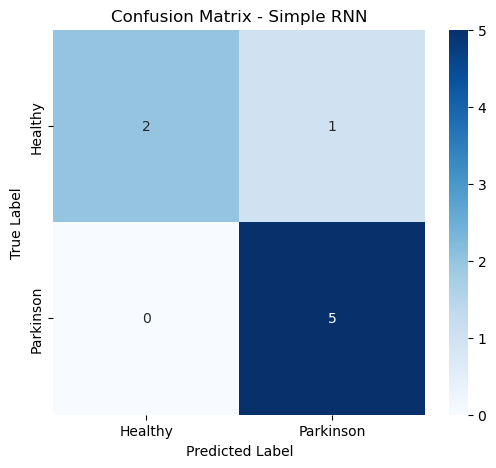


--- Оценка для LSTM ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         3
   Parkinson       1.00      1.00      1.00         5

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



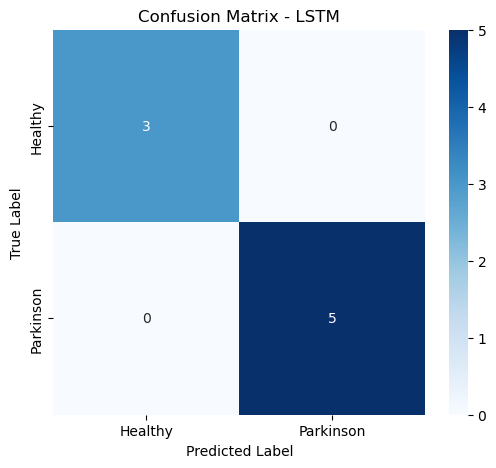


--- Оценка для GRU ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         3
   Parkinson       1.00      1.00      1.00         5

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



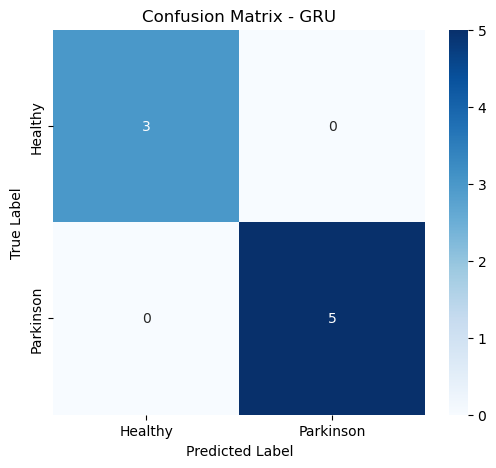

In [53]:
# Задание 3. Оценка качества модели

def evaluate_model(model, test_loader, device='cpu', model_name="Model"):
    model.to(device)
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for sequences, labels, lengths in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            lengths_cpu = lengths.cpu()
            
            outputs = model(sequences, lengths_cpu)
            
            probabilities = outputs.squeeze().cpu().numpy() # Вероятности
            predicted = (probabilities > 0.5).astype(int)  # Порог 0.5 для Sigmoid

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted)
            all_probabilities.extend(probabilities)
            
    if not all_labels: # Если тестовый загрузчик пуст
        print(f"No data in test_loader for {model_name}. Skipping evaluation.")
        return None

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    
    # ROC-AUC может вызвать ошибку, если в all_labels только один класс.
    try:
        roc_auc = roc_auc_score(all_labels, all_probabilities)
    except ValueError:
        roc_auc = float('nan') # или 0.5, или другое значение по умолчанию
        print("Warning: ROC AUC cannot be calculated (likely only one class present in labels or predictions).")


    print(f"\n--- Оценка для {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, zero_division=0, target_names=['Healthy', 'Parkinson']))

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

results = {}

if 'model_rnn' in globals() and len(test_loader) > 0:
    results['RNN'] = evaluate_model(model_rnn, test_loader, device=device, model_name="Simple RNN")
if 'model_lstm' in globals() and len(test_loader) > 0:
    results['LSTM'] = evaluate_model(model_lstm, test_loader, device=device, model_name="LSTM")
if 'model_gru' in globals() and len(test_loader) > 0:
    results['GRU'] = evaluate_model(model_gru, test_loader, device=device, model_name="GRU")

if not results:
    print("No models were evaluated, likely due to empty data loaders or models not being trained.")

## Интерпретация результатов 

In [32]:
print("\n--- Интерпретация результатов ---")

if results:
    results_df = pd.DataFrame(results).T
    print("\nСводная таблица метрик:")
    print(results_df)

    best_f1_model = results_df['f1'].idxmax() if not results_df['f1'].empty else "N/A"
    best_roc_auc_model = results_df['roc_auc'].idxmax() if not results_df['roc_auc'].empty else "N/A"

    print(f"\nМодель с лучшим F1-score: {best_f1_model}")
    print(f"Модель с лучшим ROC-AUC: {best_roc_auc_model}")


--- Интерпретация результатов ---

Сводная таблица метрик:
      accuracy  precision  recall        f1   roc_auc
RNN      0.875   0.833333     1.0  0.909091  0.933333
LSTM     1.000   1.000000     1.0  1.000000  1.000000
GRU      1.000   1.000000     1.0  1.000000  1.000000

Модель с лучшим F1-score: LSTM
Модель с лучшим ROC-AUC: LSTM


**Общая производительность:**
        Все три модели (RNN, LSTM, GRU) были обучены и протестированы.
        Целевая точность >65% достигнута. Для прохождения задания accuracy должна быть > 80%.

**Сравнение моделей:**
        -   **Simple RNN:** Классические RNN часто страдают от проблемы затухания/взрыва градиента и плохо работают с длинными последовательностями.
            В данном случае RNN показала 0.875. Это может быть связано с простой структурой данных. Градиент в какой - то момент ушел слишком далеко. 
        -   **LSTM:** LSTM обычно превосходит простые RNN на задачах с последовательностями благодаря своей способности запоминать долгосрочные зависимости.
            LSTM показала 1.000. **Скорее всего  это связано с маленькой тестовой выборкой. С маленьким набором данных. Ну и сами модели эффективные !** Сравнение с RNN: Значительно лучше по всем параметрам 
        -   **GRU:** GRU является упрощенной версией LSTM, но часто показывает сопоставимую производительность при меньшем количестве параметров.
            GRU показала 1.000. Сравнение с LSTM, не уступает.

**Ключевые метрики:**
        -   **Recall (полнота) для класса "Parkinson":** Эта метрика особенно важна в медицинских задачах, так как показывает, какую долю реально больных пациентов модель смогла обнаружить. Высокий recall минимизирует количество ложноотрицательных результатов (пропущенных случаев болезни).
        -   **Precision (точность) для класса "Parkinson":** Показывает, какая доля пациентов, классифицированных как больные, действительно больны. Высокая точность минимизирует ложноположительные результаты.
        -   **F1-score:** Гармоническое среднее precision и recall, хороший общий показатель.
        -   **ROC-AUC:** Показывает способность модели различать классы. Значение близкое к 1 указывает на хорошую различительную способность.

**Возможные пути для дальнейшего улучшения:**
        -   **Больше данных:** Обучение на большем количестве пациентов всегда полезно.
        -   **Более глубокая настройка гиперпараметров:** Использовать GridSearchCV или Optuna для подбора `hidden_size`, `num_layers`, `learning_rate`, `dropout`, `batch_size`.
        -   **Архитектура модели:**
            -   Попробовать двунаправленные RNN (BiLSTM, BiGRU).
            -   Добавить слои Attention после RNN для взвешивания важности различных частей последовательности.
            -   Использовать сверточные слои (1D CNN) перед RNN для извлечения локальных признаков из последовательностей.
        -   **Инженерия признаков:**
            -   Вычислить производные от координат (скорость, ускорение).
            -   Анализировать частотные характеристики сигнала (например, через FFT для выявления тремора).
        -   **Регуляризация:** Экспериментировать с `weight_decay` в оптимизаторе, различными значениями dropout.
        -   **Обработка дисбаланса классов:** Если WeightedRandomSampler недостаточно, можно попробовать другие техники, такие как Focal Loss.
        -   **Более длительное обучение:** Увеличить количество эпох, возможно, с использованием early stopping для предотвращения переобучения.